In [1]:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from math import pi as PI
from math import exp as exp



def analytical_solution(NT, NX, TMAX, XMAX, NU):
   """
   Returns the velocity field and distance for the analytical solution
   """

   # Increments
   DT = TMAX/(NT-1)
   DX = XMAX/(NX-1)

   # Initialise data structures
   import numpy as np
   u_analytical = np.zeros((NX,NT))
   x = np.zeros(NX)
   _t = np.zeros(NT)

   # Distance
   for i in range(0,NX):
       x[i] = i*DX

   # Analytical Solution
   for n in range(0,NT):
       t = n*DT
       _t[n] = n*DT

       for i in range(0,NX):
           phi = exp( -(x[i]-4*t)**2/(4*NU*(t+1)) ) + exp( -(x[i]-4*t-2*PI)**2/(4*NU*(t+1)) )

           dphi = ( -0.5*(x[i]-4*t)/(NU*(t+1))*exp( -(x[i]-4*t)**2/(4*NU*(t+1)) )
               -0.5*(x[i]-4*t-2*PI)/(NU*(t+1))*exp( -(x[i]-4*t-2*PI)**2/(4*NU*(t+1)) ) )

           u_analytical[i,n] = -2*NU*np.nan_to_num(dphi/phi) + 4

   return u_analytical, x, _t

In [38]:
nu = 0.1 * 10
u_analytical, x, t = analytical_solution(500, 501, 1.0, 2*np.pi, nu)
noise_level = 1e-1

# noise = noise_level * (
#     (u_analytical.max()-u_analytical.min()) *
#     np.random.randn(u_analytical.shape[0],u_analytical.shape[1])
# )
# u_noisy = u_analytical + noise

noise = noise_level * (
    np.random.randn(u_analytical.shape[0],u_analytical.shape[1])
)
u_noisy = u_analytical * (1 + noise)

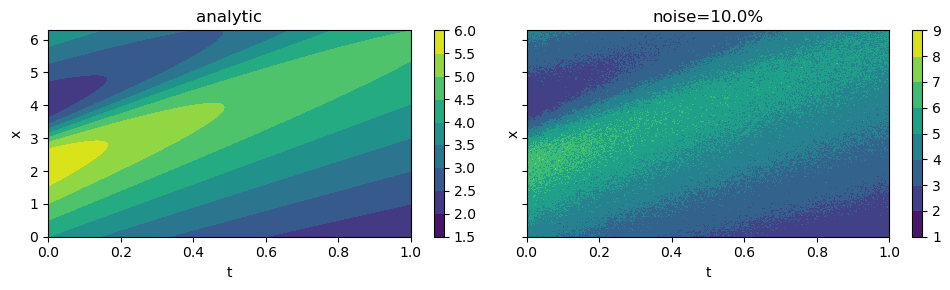

In [39]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10,3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    cax=axs[ifig].contourf(
        t, x, u
    )
    axs[ifig].set(
        title=titles[ifig],
        xlabel='t', ylabel='x'
    )
    fig.colorbar(cax, ax=axs[ifig])
fig.tight_layout()

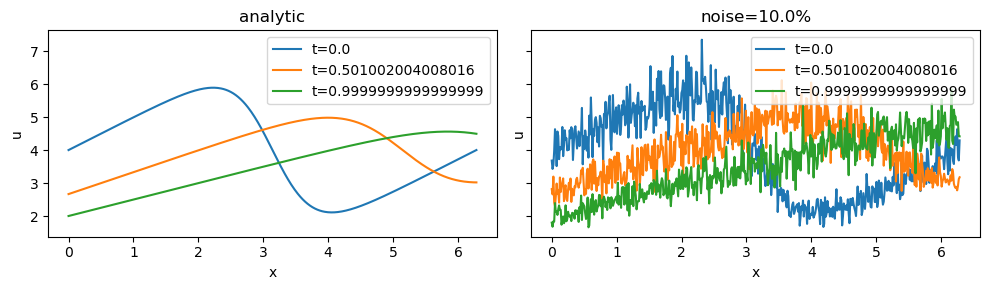

In [40]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10, 3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    for i in [0,len(t)//2,-1]:
        axs[ifig].plot(
            x, u[:,i], label='t={}'.format(t[i])
        )
    axs[ifig].legend()
    axs[ifig].set(
        title=titles[ifig],
        xlabel='x', ylabel='u'
    )
fig.tight_layout()


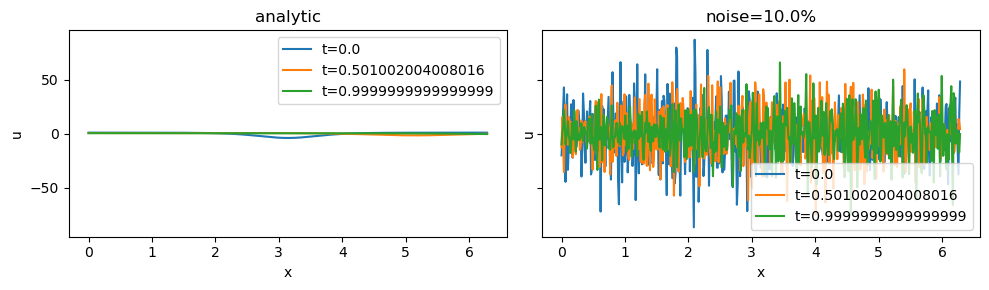

In [41]:
fig, axs = plt.subplots(
    nrows=1, ncols=2, 
    sharex=True, sharey=True,
    figsize=(10, 3), dpi=100
)
titles=['analytic', 'noise={}%'.format(noise_level*100)]
for ifig, u in enumerate([u_analytical, u_noisy]):
    for i in [0,len(t)//2,-1]:
        axs[ifig].plot(
            x, np.gradient(u[:,i], x), 
            label='t={}'.format(t[i])
        )
    axs[ifig].legend()
    axs[ifig].set(
        title=titles[ifig],
        xlabel='x', ylabel='u'
    )
fig.tight_layout()


(100, 100)
(286,) (286,)


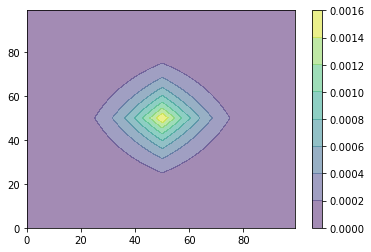

In [67]:
i0 = 0; i1 = u_noisy.shape[0]
j0 = 0; j1 = u_noisy.shape[1]
i_pow = 3
j_pow = 3

i_int_size = int(i1*0.2)
j_int_size = int(j1*0.2)
j_int_mesh, i_int_mesh = np.meshgrid(
    np.arange(j_int_size) - (j_int_size//2),
    np.arange(i_int_size) - (i_int_size//2),
)
i_int_weight = abs( i_int_mesh ).astype(float)
i_int_weight /= np.max(i_int_weight)
i_int_weight = np.power(1 - i_int_weight, i_pow)

j_int_weight = abs( j_int_mesh ).astype(float)
j_int_weight /= np.max(j_int_weight)
j_int_weight = np.power(1 - j_int_weight, j_pow)

integral_weight = i_int_weight * j_int_weight
integral_weight /= np.sum(integral_weight)

print(integral_weight.shape)

plt.contourf(integral_weight, alpha=0.5)
plt.colorbar()

# N_samples = u_noisy.size // integral_weight.size // 10
N_samples = u_noisy.shape[1]

eval_j0 = (
    np.unique(
        np.random.choice(
            np.arange(j0, j1-j_int_size, 1), 
            size=N_samples
        )
    )
)
eval_i0 = (
    (
        np.random.choice(
            np.arange(i0, i1-i_int_size, 1), 
            size=eval_j0.size
        )
    )
)
print(eval_i0.shape, eval_j0.shape)

In [69]:
# u=[]; u_t=[]; u_tt=[]; u_x=[]; u_xx=[];
# u_t_clean=[];
# t_points=[]; x_points=[];

# from scipy.interpolate import SmoothBivariateSpline as Bspline
# # from scipy.interpolate import LSQBivariateSpline as Bspline

# for _i, _j in zip(eval_i0[:1], eval_j0[:1]):
#     x_points.append(x[_i]);
#     t_points.append(t[_j]);
#     _tt, _xx = np.meshgrid(
#         t[_j:_j+j_int_size],
#         x[_i:_i+i_int_size],
#     )
#     u_spl = Bspline(
#         _xx.flatten(), _tt.flatten(),
#         u_noisy[_i:_i+i_int_size,_j:_j+j_int_size].flatten(),
# #         x[_i:_i+i_int_size], t[_j:_j+j_int_size], 
#         kx=i_pow, ky=j_pow
#     )
# #     _i = eval_i0[0]
# #     _j = eval_j0[0]
#     _uu = u_spl(
#         x[_i:_i+i_int_size], t[_j:_j+j_int_size], 
#         grid=True
#     )

#     plt.subplot(211)
#     plt.pcolormesh(
#         x[_i:_i+i_int_size], t[_j:_j+j_int_size], 
#         u_noisy[_i:_i+i_int_size,_j:_j+j_int_size].T, 
#     )
#     plt.colorbar()

#     plt.subplot(212)
#     plt.pcolormesh(
#         x[_i:_i+i_int_size], t[_j:_j+j_int_size],
#         _uu.T
#     )
#     plt.colorbar()

In [70]:
u=[]; u_t=[]; u_tt=[]; u_x=[]; u_xx=[];
u_t_clean=[];
t_points=[]; x_points=[];

from scipy.interpolate import SmoothBivariateSpline as Bspline

for _i, _j in zip(eval_i0[:], eval_j0[:]):
    x_points.append(x[_i]);
    t_points.append(t[_j]);
    _x_1d = x[_i:_i+i_int_size]
    _t_1d = t[_j:_j+j_int_size]
    _tt, _xx = np.meshgrid(
         _t_1d, _x_1d,
    )
    u_spl = Bspline(
        _xx.flatten(), _tt.flatten(),
        u_noisy[_i:_i+i_int_size,_j:_j+j_int_size].flatten(),
        kx=i_pow, ky=j_pow
    )
    
    _u = u_spl(
        _x_1d, _t_1d, 
        dx=0, dy=0, 
        grid=True
    )
    _u_x = u_spl(
        _x_1d, _t_1d,
        dx=1, dy=0, 
        grid=True
    )
    _u_xx = u_spl(
        _x_1d, _t_1d,
        dx=2, dy=0, 
        grid=True
    )
    _u_t = u_spl(
        _x_1d, _t_1d,
        dx=0, dy=1, 
        grid=True
    )
    _u_tt = u_spl(
        _x_1d, _t_1d,
        dx=0, dy=2, 
        grid=True
    )
    
    u.append( np.sum(_u * integral_weight) )
    u_t.append( np.sum(_u_t * integral_weight) )
    u_tt.append( np.sum(_u_tt * integral_weight) )
    u_x.append( np.sum(_u_x * integral_weight) )
    u_xx.append( np.sum(_u_xx * integral_weight) )

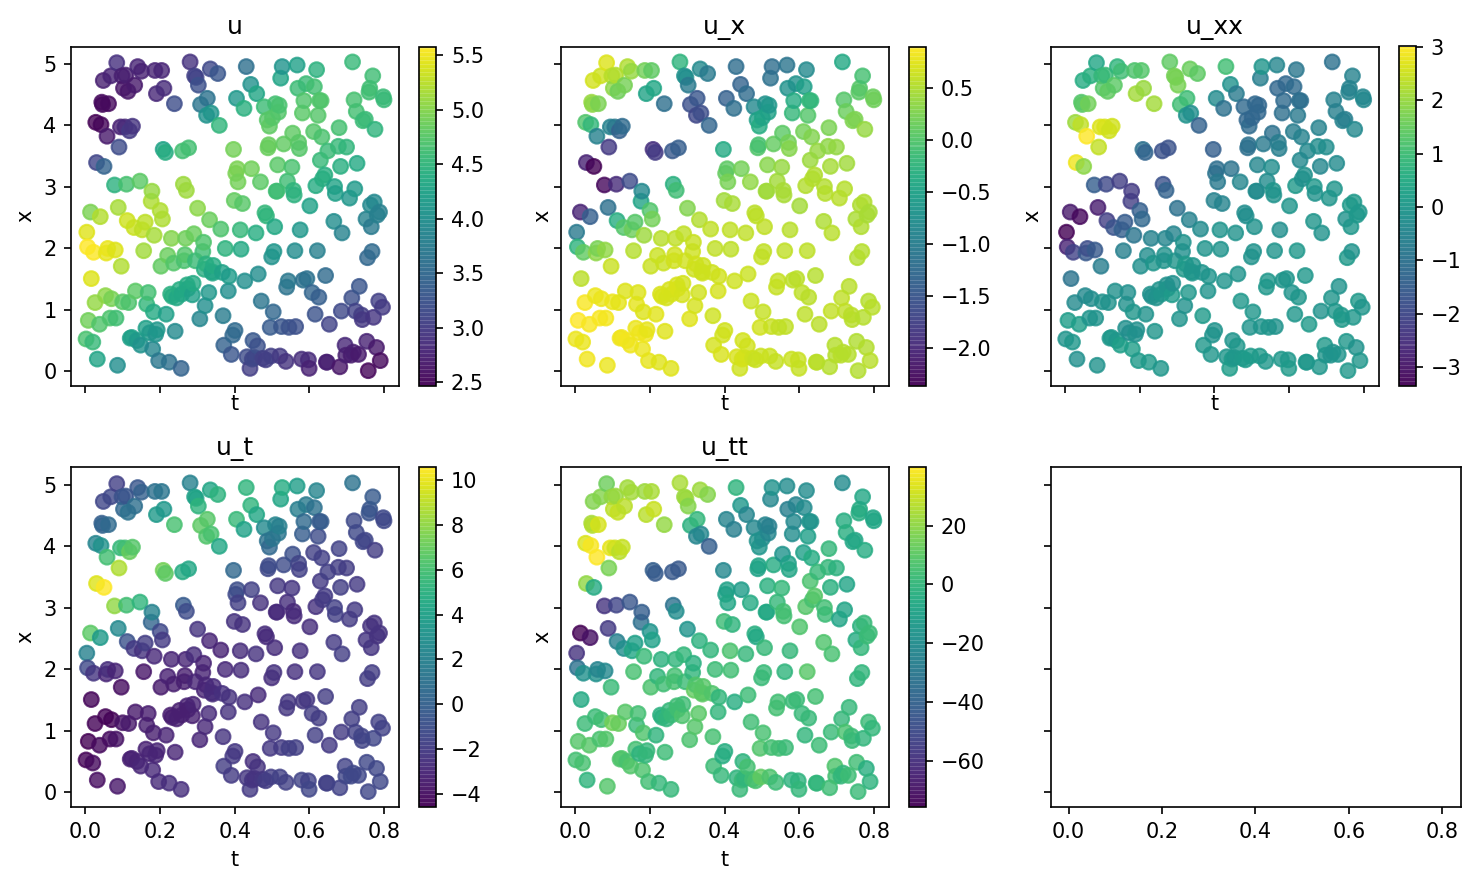

In [71]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, 
    figsize=(10,6), dpi=150,
    sharex=True, sharey=True
)
axs = axs.flatten()
for ifig,f,title in zip(
    range(5),
    [u, u_x, u_xx, u_t, u_tt], 
    ['u', 'u_x', 'u_xx', 'u_t', 'u_tt'], 
):
    ax = axs[ifig]
    ax.set(
        title=title, xlabel='t', ylabel='x'
    )
    cax=ax.scatter(
        t_points, x_points, c=f, s=50, alpha=0.8
    )
    fig.colorbar(cax,ax=ax)
fig.tight_layout()

In [72]:
import warnings

import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ridge_regression
from sklearn.utils.validation import check_is_fitted

from pysindy import BaseOptimizer, STLSQ


class STLSQ_mod(BaseOptimizer):
    """Sequentially thresholded least squares algorithm.
    Attempts to minimize the objective function
    :math:`\\|y - Xw\\|^2_2 + \\alpha \\|w\\|^2_2`
    by iteratively performing least squares and masking out
    elements of the weight array w that are below a given threshold.
    See the following reference for more details:
        Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz.
        "Discovering governing equations from data by sparse
        identification of nonlinear dynamical systems."
        Proceedings of the national academy of sciences
        113.15 (2016): 3932-3937.
    Parameters
    ----------
    threshold : float, optional (default 0.1)
        Minimum magnitude for a coefficient in the weight vector.
        Coefficients with magnitude below the threshold are set
        to zero.
    alpha : float, optional (default 0.05)
        Optional L2 (ridge) regularization on the weight vector.
    max_iter : int, optional (default 20)
        Maximum iterations of the optimization algorithm.
    ridge_kw : dict, optional (default None)
        Optional keyword arguments to pass to the ridge regression.
    fit_intercept : boolean, optional (default False)
        Whether to calculate the intercept for this model. If set to false, no
        intercept will be used in calculations.
    normalize : boolean, optional (default False)
        This parameter is ignored when fit_intercept is set to False. If True,
        the regressors X will be normalized before regression by subtracting
        the mean and dividing by the l2-norm.
    copy_X : boolean, optional (default True)
        If True, X will be copied; else, it may be overwritten.
    initial_guess : np.ndarray, shape (n_features) or (n_targets, n_features), \
            optional (default None)
        Initial guess for coefficients ``coef_``.
        If None, least-squares is used to obtain an initial guess.
    Attributes
    ----------
    coef_ : array, shape (n_features,) or (n_targets, n_features)
        Weight vector(s).
    ind_ : array, shape (n_features,) or (n_targets, n_features)
        Array of 0s and 1s indicating which coefficients of the
        weight vector have not been masked out, i.e. the support of
        ``self.coef_``.
    history_ : list
        History of ``coef_``. ``history_[k]`` contains the values of
        ``coef_`` at iteration k of sequentially thresholded least-squares.
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.integrate import odeint
    >>> from pysindy import SINDy
    >>> from pysindy.optimizers import STLSQ
    >>> lorenz = lambda z,t : [10*(z[1] - z[0]),
    >>>                        z[0]*(28 - z[2]) - z[1],
    >>>                        z[0]*z[1] - 8/3*z[2]]
    >>> t = np.arange(0,2,.002)
    >>> x = odeint(lorenz, [-8,8,27], t)
    >>> opt = STLSQ(threshold=.1, alpha=.5)
    >>> model = SINDy(optimizer=opt)
    >>> model.fit(x, t=t[1]-t[0])
    >>> model.print()
    x0' = -9.999 1 + 9.999 x0
    x1' = 27.984 1 + -0.996 x0 + -1.000 1 x1
    x2' = -2.666 x1 + 1.000 1 x0
    """

    def __init__(
        self,
        threshold=0.1,
        target_number_terms=3,
        alpha=0.05,
        max_iter=20,
        ridge_kw=None,
        normalize=False,
        fit_intercept=False,
        copy_X=True,
        initial_guess=None,
    ):
        super(STLSQ_mod, self).__init__(
            max_iter=max_iter,
            normalize=normalize,
            fit_intercept=fit_intercept,
            copy_X=copy_X,
        )

        if threshold < 0:
            raise ValueError("threshold cannot be negative")
        if alpha < 0:
            raise ValueError("alpha cannot be negative")

        self.threshold = threshold
        self.target_n_terms = target_number_terms
        self.alpha = alpha
        self.ridge_kw = ridge_kw
        self.initial_guess = initial_guess

    def _sparse_coefficients(self, dim, ind, coef, threshold):
        """Perform thresholding of the weight vector(s)"""
        c = np.zeros(dim)
        c[ind] = coef
        # remove lowest value coefficient
        big_ind = np.abs(c) > np.abs(coef).min()
        c[~big_ind] = 0
        return c, big_ind

    def _regress(self, x, y):
        """Perform the ridge regression"""
        kw = self.ridge_kw or {}
        coef = ridge_regression(x, y, self.alpha, **kw)
        self.iters += 1
        return coef

    def _no_change(self):
        """Check if the coefficient mask has changed after thresholding"""
        this_coef = self.history_[-1].flatten()
        if len(self.history_) > 1:
            last_coef = self.history_[-2].flatten()
        else:
            last_coef = np.zeros_like(this_coef)
        return all(bool(i) == bool(j) for i, j in zip(this_coef, last_coef))

    def _reduce(self, x, y):
        """Performs at most ``self.max_iter`` iterations of the
        sequentially-thresholded least squares algorithm.
        Assumes an initial guess for coefficients and support are saved in
        ``self.coef_`` and ``self.ind_``.
        """

        ind = self.ind_
        n_samples, n_features = x.shape
        n_targets = y.shape[1]
        n_features_selected = np.sum(ind)
        
        if self.initial_guess is not None:
            self.coef_ = self.initial_guess
        else:
            self.coef_ = (np.random.rand(n_targets, n_features) - 0.5) * 2.0

        for _ in range(self.max_iter):
            if np.count_nonzero(ind) == 0:
                warnings.warn(
                    "Sparsity parameter is too big ({}) and eliminated all "
                    "coefficients".format(self.threshold)
                )
                coef = np.zeros((n_targets, n_features))
                break

            coef = np.zeros((n_targets, n_features))
            for i in range(n_targets):
                if np.count_nonzero(ind[i]) == 0:
                    warnings.warn(
                        "Sparsity parameter is too big ({}) and eliminated all "
                        "coefficients".format(self.threshold)
                    )
                    continue
                coef_i = self._regress(x[:, ind[i]], y[:, i])
                coef_i, ind_i = self._sparse_coefficients(
                    n_features, ind[i], coef_i, self.threshold
                )
                coef[i] = coef_i
                ind[i] = ind_i
                
            self.history_.append(coef)
            if( 
#                 (np.sum(ind) == n_features_selected) or 
#                 (self._no_change()) or 
                (np.count_nonzero(ind) == self.target_n_terms)
            ):
                # could not (further) select important features
                break
        else:
            warnings.warn(
                "STLSQ._reduce did not converge after {} iterations.".format(
                    self.max_iter
                ),
                ConvergenceWarning,
            )
            try:
                coef
            except NameError:
                coef = self.coef_
                warnings.warn(
                    "STLSQ._reduce has no iterations left to determine coef",
                    ConvergenceWarning,
                )
        self.coef_ = coef
        self.ind_ = ind

    @property
    def complexity(self):
        check_is_fitted(self)

        return np.count_nonzero(self.coef_) + np.count_nonzero(
            [abs(self.intercept_) >= self.threshold]
        )

In [73]:
T = np.copy(t_points)
ind = np.argsort(T)
# U = np.vstack((u_tt, u_x, u_xx)).T[ind,:]
U = np.vstack((u_x, u_xx)).T[ind,:]
X = np.vstack(tuple(u))[ind,:]
X_dot = np.vstack(tuple(u_t))[ind,:]
print(U.shape, X.shape, X_dot.shape)
print(T.shape)
print(np.unique(T).shape)

(286, 2) (286, 1) (286, 1)
(286,)
(286,)


In [74]:
# thresholds = [] 
# complexity = []
# score = []
# for threshold in np.linspace(-5, -0, 6):
#     poly_library = ps.PolynomialLibrary(
# #         include_bias=False,  
# #         include_interaction=True, 
# #         interaction_only=False
#     )
#     opt = STLSQ_mod(threshold=np.power(10,threshold), alpha=0)
#     model = ps.SINDy(
#         feature_names=["u", "u_x", "u_xx"],
#         optimizer=opt,
#         feature_library=poly_library
#     )
#     model.fit(X, t=T, x_dot=X_dot, u=U)
# #     score.append(model.score(X, t=T, x_dot=X_dot, u=U))
#     pred = model.simulate(X[0,:], T, u=U)
#     score.append( np.mean(np.square(pred-u)) )
#     complexity.append(model.complexity)
#     thresholds.append(10**threshold)
#     print()
#     model.print(lhs=['u_t'])
# print(score)
# print(thresholds)

In [98]:
N_terms = []
score = []
for num_terms in range(1,6):
    poly_library = ps.PolynomialLibrary(
        degree=2, 
        include_bias=False,
    )
    opt = STLSQ_mod(
        threshold=np.power(10,0.0), 
        alpha=0, 
        target_number_terms=num_terms, max_iter=100
    )
    model = ps.SINDy(
        feature_names=["u", "u_x", "u_xx"],
        optimizer=opt,
        feature_library=poly_library
    )
    model.fit(X, t=T, x_dot=X_dot, u=U)
    pred = model.predict(X, u=U).flatten()
    score.append(
        np.sum(
            np.abs(
                np.nan_to_num( (pred - u_t)
            )
        )
    ) / np.sum(abs(np.array(u_t))) )
    N_terms.append(model.complexity)
    print()
    model.print(lhs=['u_t'])
print(score)
print(N_terms)


u_t = 0.755 u_xx

u_t = 1.063 u_xx + -0.988 u u_x

u_t = -0.534 u_x + 1.030 u_xx + -0.858 u u_x

u_t = 0.005 u + -0.516 u_x + 1.039 u_xx + -0.864 u u_x

u_t = 0.362 u + -1.918 u_x + 0.750 u_xx + -0.086 u^2 + -0.519 u u_x
[0.9606962771967537, 0.0797350995080592, 0.07807463318351873, 0.07705933756863896, 0.07479933680797658]
[1, 2, 3, 4, 5]


In [99]:
_x, _t = np.meshgrid(x, t)
u_t_analytical = np.gradient(u_analytical, t, axis=1)

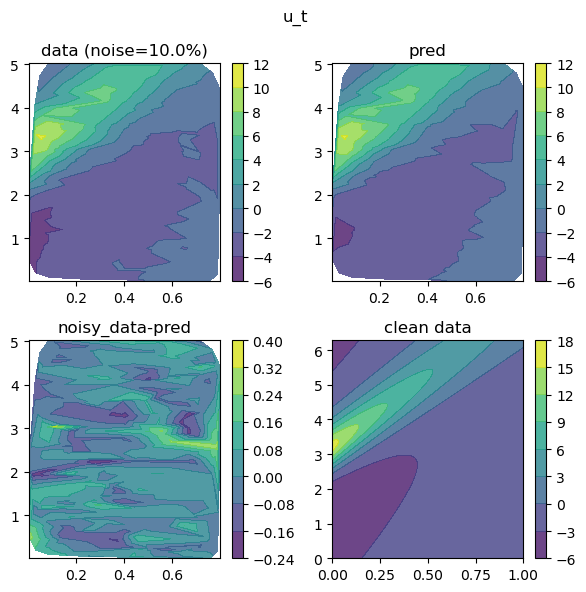

In [100]:
plt.figure(figsize=(6,6), dpi=100)
plt.suptitle('u_t')
for ifig, f, title in zip(
    range(221,224),
    [u_t, pred, 
#      u_t-pred.flatten()
     np.nan_to_num( (pred - u_t) / np.mean(abs(np.array(u_t))) ).flatten()
    ],
    ['data (noise={}%)'.format(noise_level*100),'pred','noisy_data-pred']
):
    plt.subplot(ifig)
    plt.title(title)
    plt.tricontourf(
        t_points, x_points, f, 
        alpha=0.8
    )
    plt.colorbar()
plt.subplot(224)
plt.title('clean data')
plt.contourf(
    t, x, u_t_analytical, 
    alpha=0.8
)
plt.colorbar()

plt.tight_layout()

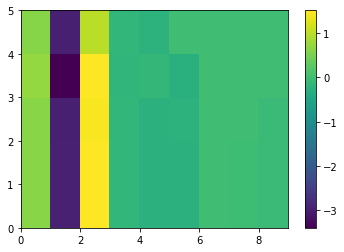

In [101]:
plt.pcolormesh(np.array(model.optimizer.history_)[:,0,:])
plt.colorbar()

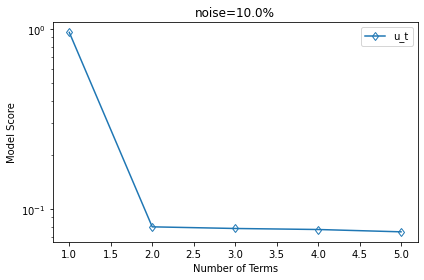

In [104]:
plt.figure()
plt.plot(
    N_terms, score, 'd-', mfc='none', label='u_t'
)
plt.legend()
plt.yscale('log')
plt.title('noise={}%'.format(noise_level*100))
plt.xlabel('Number of Terms')
plt.ylabel('Model Score')
# plt.axvline(threshold,c='k',ls='--')
plt.tight_layout()
